[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/examples/simulation_example_Gaussian.ipynb)

# Imports

In [14]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *
from lightgbmlss.datasets.data_loader import load_simulated_gaussian_data
from scipy.stats import norm

import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [2]:
# The data is simulated as a Gaussian, where x is the only true feature and all others are noise variables
# loc = 10
# scale = 1 + 4 * ((0.3 < x) & (x < 0.5)) + 2 * (x > 0.7)

train, test = load_simulated_gaussian_data()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [3]:
# Specifies Gaussian distribution with exp response function and option to stabilize Gradient/Hessian. Type ?Gaussian for an overview.
lgblss = LightGBMLSS(
    Gaussian(stabilization="None",   # Options are "None", "MAD", "L2".
             response_fn="exp")      # Function to transform the scale-parameter, e.g., "exp" or "softplus".
)

# Hyper-Parameter Optimization

In [4]:
# Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
    # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
        # param_name: str, Name of the parameter
        # value: int, Value of the parameter
    # Example: {"gpu_id": ["none", [0]]}

param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "num_leaves":               ["int",   {"low": 255,    "high": 255,   "log": False}],  # set to constant for this example
    "min_data_in_leaf":         ["int",   {"low": 20,     "high": 20,    "log": False}],  # set to constant for this example
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": False}],
    "min_sum_hessian_in_leaf":  ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-05-23 15:43:31,462] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\LightGBMLSS-Dam57Fpb\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/10:00

[I 2023-05-23 15:43:37,420] Trial 0 finished with value: 3427.318782306884 and parameters: {'eta': 0.0002313410056635787, 'max_depth': 4, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 9.76957412830834, 'min_sum_hessian_in_leaf': 0.09611246610598466, 'subsample': 0.5630992626692337, 'feature_fraction': 0.43710796660921647, 'boosting': 'gbdt'}. Best is trial 0 with value: 3427.318782306884.
[I 2023-05-23 15:43:38,583] Trial 1 finished with value: 3454.545483150493 and parameters: {'eta': 0.666364045674118, 'max_depth': 7, 'num_leaves': 255, 'min_data_in_leaf': 20, 'min_gain_to_split': 13.932688278726545, 'min_sum_hessian_in_leaf': 0.07952819503723721, 'subsample': 0.9848872455429178, 'feature_fraction': 0.5534106744520009, 'boosting': 'gbdt'}. Best is trial 0 with value: 3427.318782306884.
[I 2023-05-23 15:43:42,302] Trial 2 finished with value: 2945.2458300632893 and parameters: {'eta': 0.12699699601147338, 'max_depth': 3, 'num_leaves': 255, 'min_data_in_leaf': 20, 'mi

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,11.016262,8.640878,11.363346,11.242937,-0.744207,10.181254,14.180162,7.672113,12.747739,8.281850,...,10.979889,11.196779,8.574387,9.530920,10.547581,9.193166,11.693525,7.681727,10.003475,6.328706
1,9.413368,9.552017,10.099647,12.515983,16.333818,10.865510,9.276918,9.868771,7.633265,17.463528,...,10.461439,7.027225,2.557652,8.715987,16.236050,8.791658,8.391334,16.113825,9.168509,8.097947
2,9.625611,10.048179,10.434471,8.434316,10.799936,8.288993,10.245296,11.324380,10.762342,9.759910,...,11.364619,10.557592,8.734255,9.722808,8.587892,9.229014,9.953936,10.101137,10.667041,9.436294
3,7.208263,15.191336,9.253407,-4.016089,12.275511,8.153443,6.894386,6.065850,3.688320,13.169545,...,20.045143,15.401307,8.512722,12.179009,7.926232,13.391665,9.862572,7.999733,12.597588,7.874276
4,11.063381,10.161060,8.949221,8.589016,10.448013,8.234201,6.782615,6.850224,11.562518,4.671337,...,9.524378,12.322967,9.114133,13.246386,11.949039,7.633799,10.519113,9.097095,7.704168,11.520777


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,5.442901,14.949003
1,5.159649,14.962536
2,8.321846,11.717459
3,2.749801,17.216751
4,4.549067,15.062630


In [9]:
pred_params.head()

,loc,scale
0,10.029065,2.926153
1,9.931022,2.911812
2,9.936380,1.023858
3,9.936380,4.639561
4,9.931022,3.248259


# SHAP Interpretability

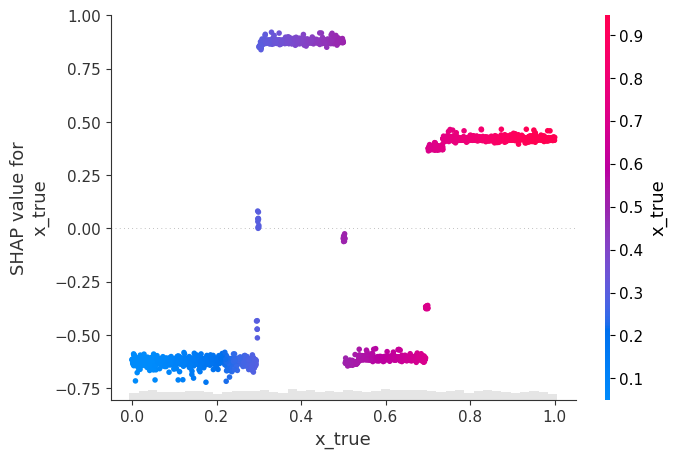

In [10]:
# Partial Dependence Plot of how x acts on variance
lgblss.plot(X_test,
            parameter="scale",
            feature="x_true",
            plot_type="Partial_Dependence")

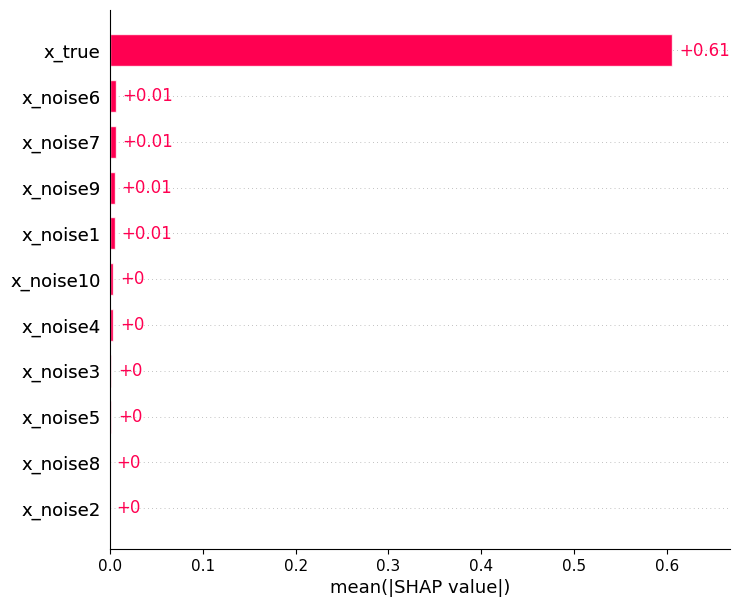

In [11]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

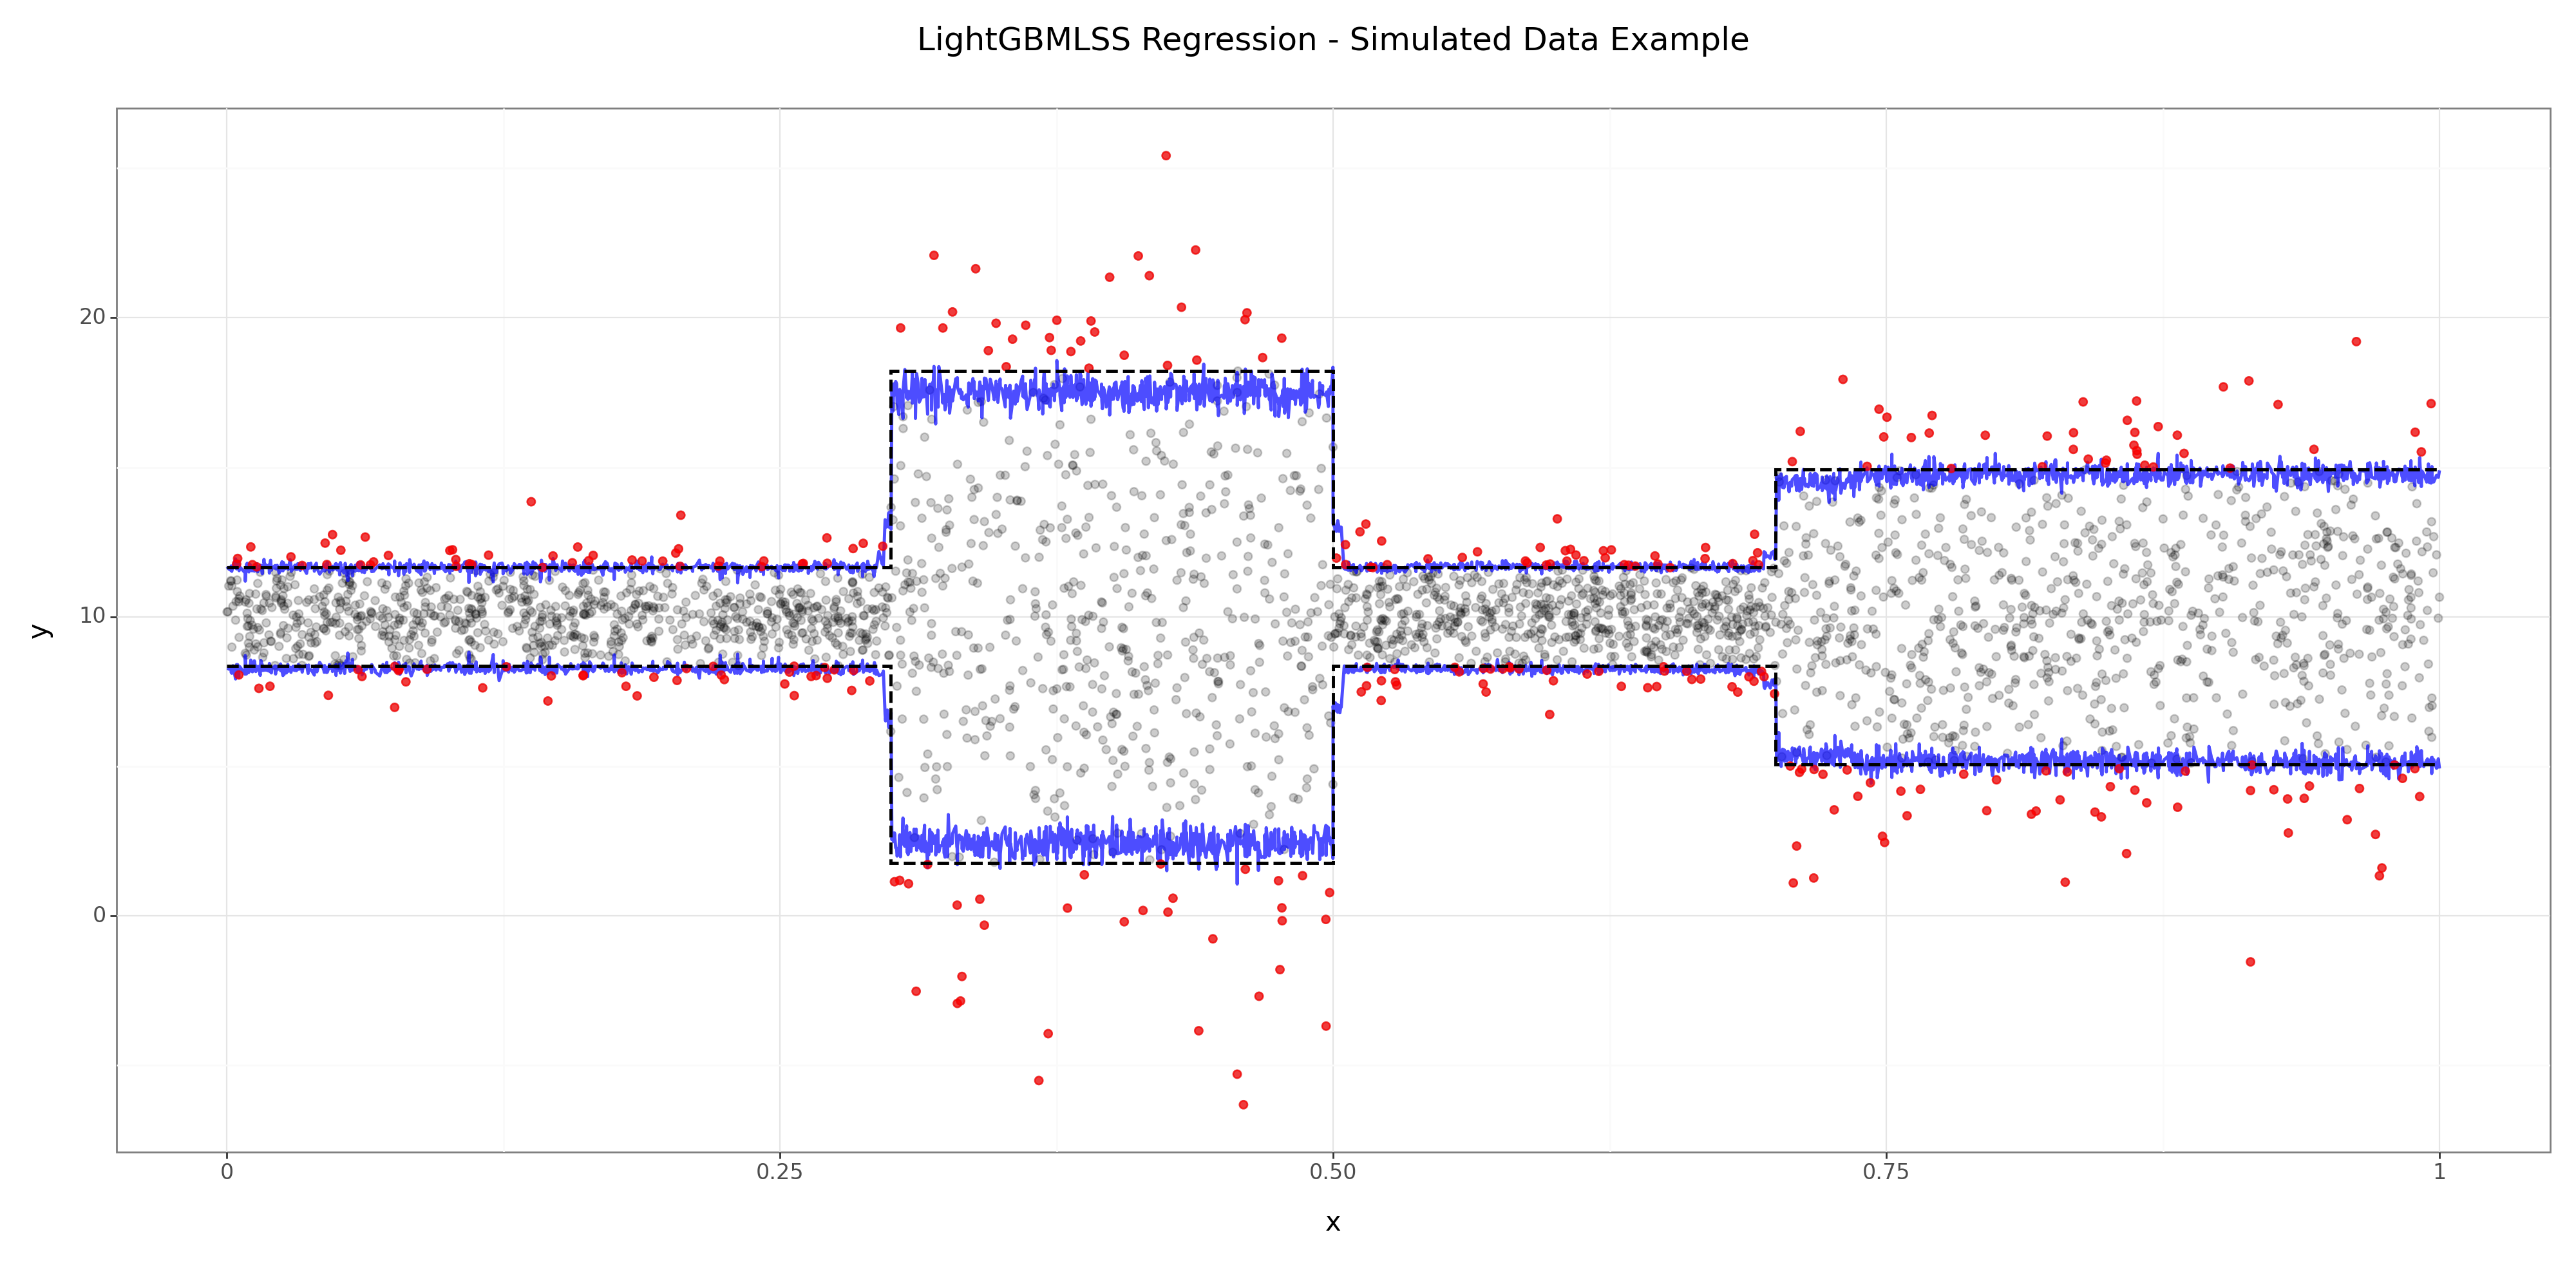

<Figure Size: (2000 x 1000)>

In [12]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x_true"].values) & (test["x_true"].values < 0.5)) + 2*(test["x_true"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x_true"].values) & (test["x_true"].values < 0.5)) + 2*(test["x_true"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1], "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1], "y":yu})

###
# Predicted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]

###
# Plot
###
(ggplot(test,
        aes("x_true",
            "y")) +
 geom_point(alpha = 0.2, color = "black", size = 2) +
 theme_bw(base_size=15) +
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "LightGBMLSS Regression - Simulated Data Example",
      x="x")  +
 geom_line(aes("x_true",
               "ub"),
           size = 1,
           color = "blue",
           alpha = 0.7) +
 geom_line(aes("x_true",
               "lb"),
           size = 1,
           color = "blue",
           alpha = 0.7) +
 geom_point(df_quantiles,
            aes("x_true",
                "y"),
            color = "red",
            alpha = 0.7,
            size = 2) +
 geom_step(sfunl,
           aes("x_true",
               "y"),
           size = 1,
           linetype = "dashed")  +
 geom_step(sfunu,
           aes("x_true",
               "y"),
           size = 1,
           linetype = "dashed")
 )

# True vs. Predicted Distributional Parameters
In the following figure, we compare the true parameters of the Gaussian with the ones predicted by XGBoostLSS. The below figure shows that the estimated parameters closely match the true ones (recall that the location parameter $\mu=10$ is simulated as being a constant).

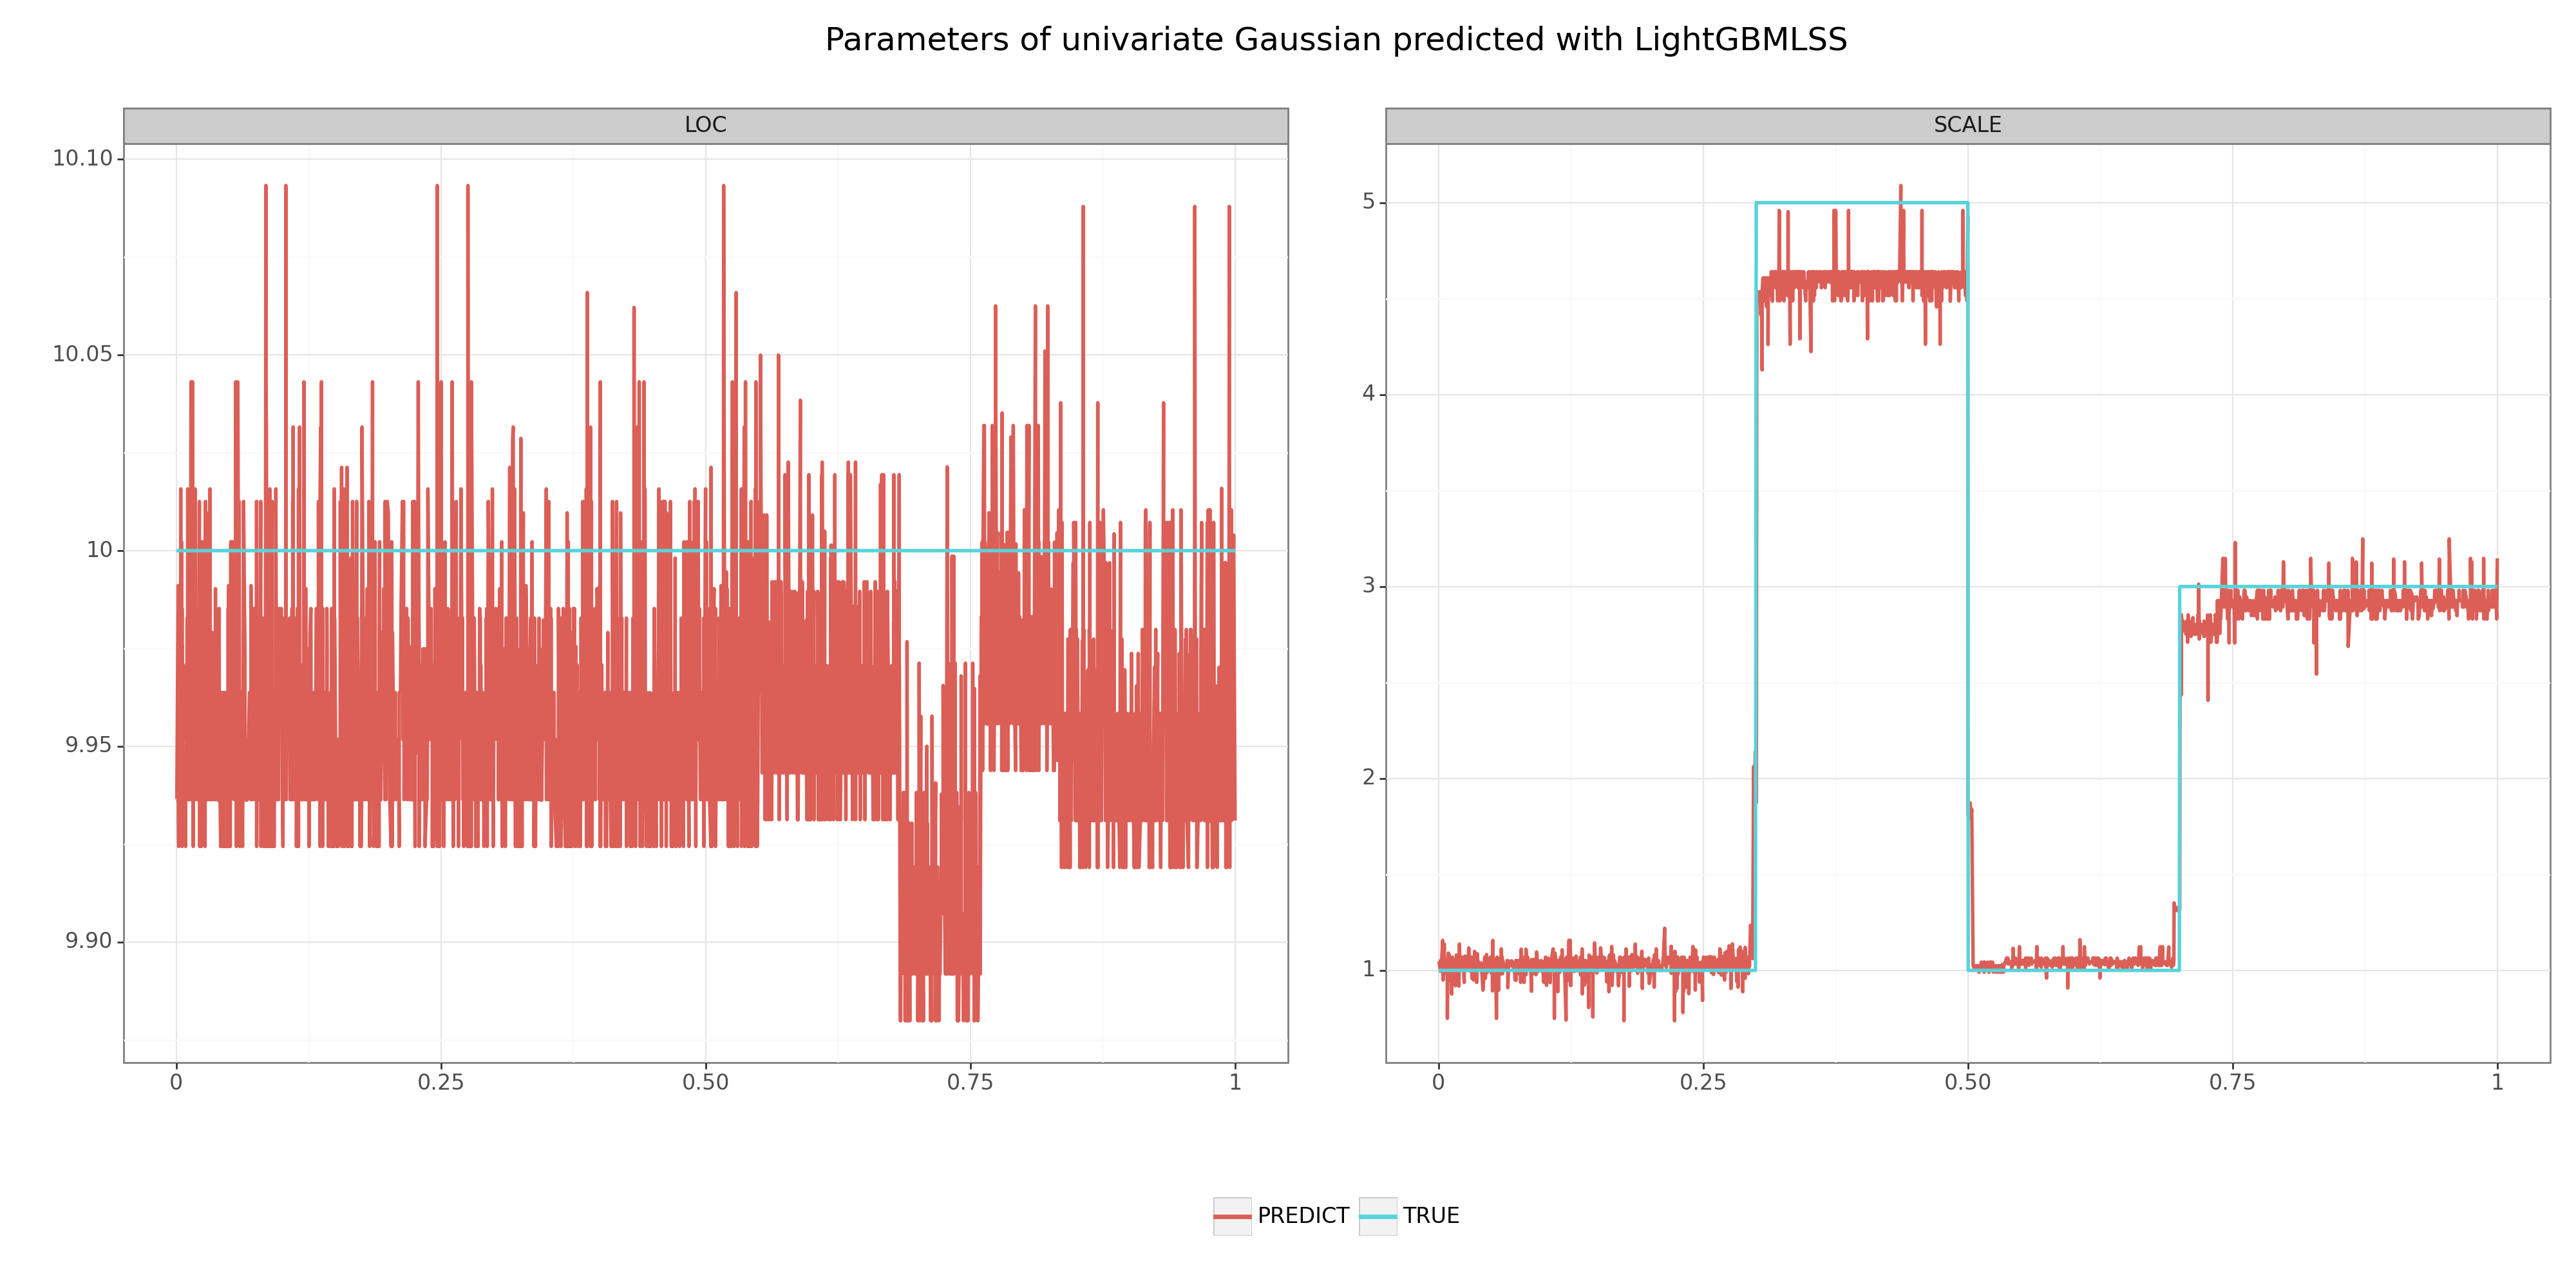

<Figure Size: (2000 x 1000)>

In [13]:
pred_params["x_true"] = X_test["x_true"].values
dist_params = list(lgblss.dist.param_dict.keys())

# Data with actual values
plot_df_actual = pd.melt(test[["x_true"] + dist_params],
                         id_vars="x_true",
                         value_vars=dist_params)
plot_df_actual["type"] = "TRUE"

# Data with predicted values
plot_df_predt = pd.melt(pred_params[["x_true"] + dist_params],
                        id_vars="x_true",
                        value_vars=dist_params)
plot_df_predt["type"] = "PREDICT"

plot_df = pd.concat([plot_df_predt, plot_df_actual])

plot_df["variable"] = plot_df.variable.str.upper()
plot_df["type"] = pd.Categorical(plot_df["type"], categories = ["PREDICT", "TRUE"])

(ggplot(plot_df,
        aes(x="x_true",
            y="value",
            color="type")) +
 geom_line(size=1.1) +
 facet_wrap("variable",
            scales="free") +
 labs(title="Parameters of univariate Gaussian predicted with LightGBMLSS",
      x="",
      y="") +
 theme_bw(base_size=15) +
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5),
       legend_title = element_blank())
 )